# Описание
Код работает с 20 признаками из текстов для обучения модели

📌 1. Признаки сложности текста:
* 1.1 avg_sentence_length – средняя длина предложений (в словах).
* 1.2 avg_word_length – средняя длина слова (в символах).
* 1.3 type_token_ratio – отношение количества уникальных слов к общему количеству слов (разнообразие лексики).

📌 2. Частотные характеристики текста:
* 2.1 special_symbols_ratio – доля специальных символов (например, @, #, $, %).
* 2.2 unique_letters_ratio – доля уникальных символов в тексте.
* 2.3 uppercase_ratio – доля заглавных букв.
* 2.4 latin_ratio – доля латинских букв (возможно, для выявления вставок на английском).
* 2.5 long_words_ratio - рассчитывает долю слов длиной более 7 символов.

📌 3. Функциональные слова:
* 3.1 stop_words_ratio – доля стоп-слов (общих служебных слов, не несущих смысла).

📌 4. Частотность частей речи (POS-теги):
* 4.1 NOUN_ratio – доля существительных.
* 4.2 VERB_ratio – доля глаголов.
* 4.3 ADJ_ratio – доля прилагательных.
* 4.4 ADV_ratio – доля наречий.
* 4.5 PRON_ratio – доля местоимений.
* 4.6 CCONJ_ratio – доля сочинительных союзов.
* 4.7 SCONJ_ratio – доля подчинительных союзов.
* 4.8 ADP_ratio – доля предлогов.
* 4.9 AUX_ratio – доля вспомогательных глаголов.
  
📌 5. Синтаксическая сложность:
* 5.1 max_depth – максимальная глубина дерева зависимостей в предложении (сложность синтаксических конструкций).
* 5.2 avg_depth – средняя глубина зависимостей.

# Библиотеки для корректной работы

In [ ]:
import numpy as np
import pandas as pd
import spacy
import re
import torch
import string
import nltk
import textwrap
# так загружается ru_core_news_sm
!python -m spacy download ru_core_news_sm 
import pickle
import requests
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import json
import datetime as dt
import seaborn as sns
from datetime import datetime, date

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

from bs4 import BeautifulSoup
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from transformers import BertTokenizer, BertModel
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist

nltk.download('punkt_tab')
nltk.download('stopwords')

# 1. Загрузка, предварительный анализ файла

In [2]:
# Загрузка SpaCy-модели для русского языка
nlp = spacy.load('ru_core_news_sm')

# Загружаем NLTK-стоп-слова
stop_words = set(stopwords.words("russian"))
special_symbols = set("!@#$%^&*()_+-=[]{};:'\",.<>?/")

In [ ]:
# Импортируем данные

#загрузим данные из pkl-сета в рабочий дататсет
with open('text_train.pkl', 'rb') as file:
    data = pickle.load(file)

In [4]:
data.head()

,transcript_parts,category_parts,sub_category_parts,theme_parts,matrix_name,matrix_language,cheating_percent,cheating,answer_length,answer_length_tokens,cheating_20%
1206,[interviewer: Что такое Apache Spark и какие е...,[Hadoop],[Spark],"[Spark Core, Spark SQL, Spark Streaming]",DE+Hadoop,ru,0.0,0,"[[1234, 1292, 1788]]","[[451, 241, 670]]",0
1987,[interviewer: Что такое тестирование?\ntrainee...,[QA Engineer],[Теория тестирования],[Основные понятия],QAEngineer,ru,0.0,0,"[[0, 0, 0]]","[[0, 0, 0]]",0
2133,[interviewer: Explain the concept of an algori...,[Java],[ALGORITHMS AND DATA STRUCTURES],[Algorithms],Java,en,0.0,0,"[[776, 473, 817]]","[[145, 99, 177]]",0
1778,[interviewer: Что такое Apache Kafka и для чег...,"[Apache Kafka / Apache Airflow, Apache Kafka /...","[Введение в Apache Kafka, Введение в Apache Ka...","[Архитектура Apache Kafka и её компоненты, Осн...",DE+Hadoop,ru,0.0,0,"[[0, 4, 0], [0, 0, 0]]","[[0, 2, 0], [0, 0, 0]]",0
240,[interviewer: Что такое пользовательская истор...,"[Технические знания по BA, QA, Design, Техниче...","[BA, BA, BA, BA, BA, BA, BA, QA, QA, QA, QA, Q...","[Работа с требованиями, Критерии подготовленно...",PM,ru,0.0,0,"[[440, 580, 570], [467, 555, 419], [1442, 707,...","[[167, 233, 224], [186, 246, 170], [573, 298, ...",0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2472 entries, 1206 to 1614
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   transcript_parts      2472 non-null   object 
 1   category_parts        2472 non-null   object 
 2   sub_category_parts    2472 non-null   object 
 3   theme_parts           2472 non-null   object 
 4   matrix_name           2472 non-null   object 
 5   matrix_language       2472 non-null   object 
 6   cheating_percent      2472 non-null   float64
 7   cheating              2472 non-null   int64  
 8   answer_length         2472 non-null   object 
 9   answer_length_tokens  2472 non-null   object 
 10  cheating_20%          2472 non-null   int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 231.8+ KB


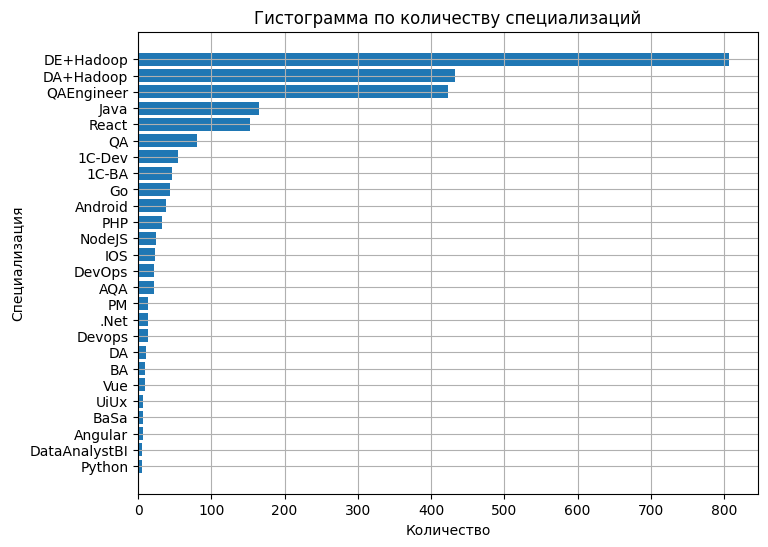

In [6]:
counts = data['matrix_name'].value_counts(ascending=True)

plt.figure(figsize=(8, 6))
plt.barh(counts.index, counts.values)
plt.xlabel('Количество')
plt.ylabel('Специализация')
plt.title('Гистограмма по количеству специализаций')
plt.grid(True)
plt.show()

Так же проанализируем, как распределяются внутри специализаций группы читинг/нечитинг

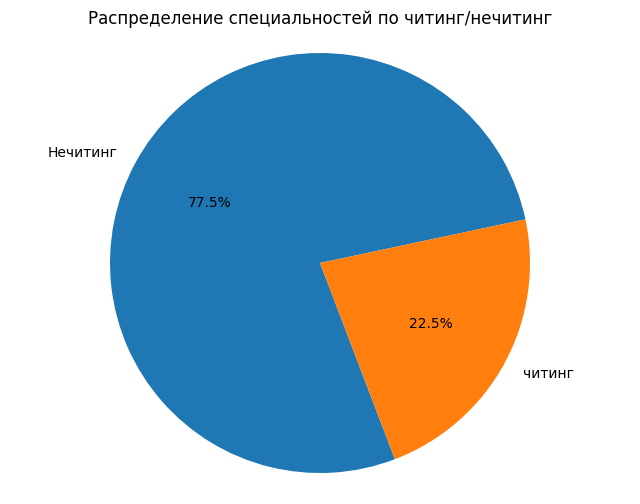

In [7]:
data_count=pd.DataFrame(data.groupby('cheating_20%')['matrix_name'].count().reset_index())

# Рисуем круговую диаграмму
plt.figure(figsize=(8, 6))
plt.pie(data_count['matrix_name'], labels=['Нечитинг', 'читинг'], autopct='%1.1f%%', startangle=12)
plt.title('Распределение специальностей по читинг/нечитинг')
plt.axis('equal')
plt.show()

In [8]:
data_count

,cheating_20%,matrix_name
0,0,1915
1,1,557


Первые 5 специализаций забирают большую часть датасета

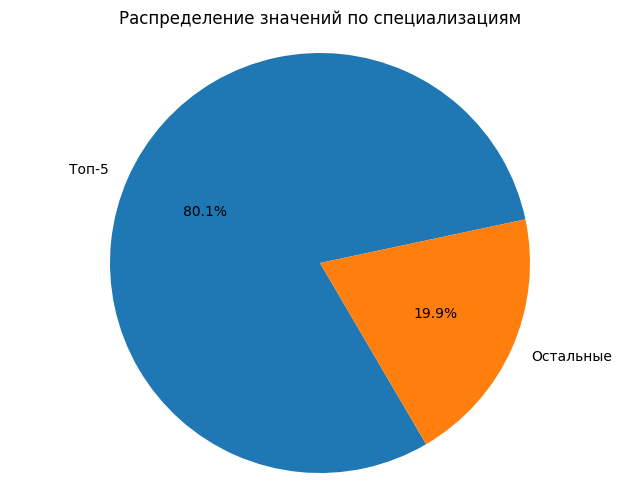

In [9]:
df=pd.DataFrame(counts).sort_values(by='count', ascending=False).reset_index()

# Первые пять записей (топ-5)
top_5 = df.head(5)
# Остальные записи
others = df.tail(df.shape[0] - 5)

# Сумма значений для топ-5
top_5_sum = top_5['count'].sum()
# Сумма значений для остальных
others_sum = others['count'].sum()

# Объединение данных для круговой диаграммы
pie_data = {'Group': ['Топ-5', 'Остальные'],
            'Sum': [top_5_sum, others_sum]}
pie_df = pd.DataFrame(pie_data)

# Рисуем круговую диаграмму
plt.figure(figsize=(8, 6))
plt.pie(pie_df['Sum'], labels=pie_df['Group'], autopct='%1.1f%%', startangle=12)
plt.title('Распределение значений по специализациям')
plt.axis('equal')
plt.show()

Посмотрим, как в топ5 распределен читинг, насколько сбалансированным является такой датафрейм

In [10]:
top_5

,matrix_name,count
0,DE+Hadoop,806
1,DA+Hadoop,433
2,QAEngineer,423
3,Java,165
4,React,153


In [11]:
#группируем по спеицализациям, с учетом только тех текстов, которые признаны читингом
data_cheat=pd.DataFrame(data[data['cheating_20%']==1].groupby(['matrix_name'])['cheating_20%'].count()).reset_index()

#объединим две таблицы по matrix_name, левый join
merge_cheat=top_5.merge(data_cheat, on='matrix_name', how='left')
merge_cheat['percent']=round(merge_cheat['cheating_20%']/merge_cheat['count']*100,2)
merge_cheat.columns=['matrix_name', 'count', 'cheating', 'percent']
merge_cheat

,matrix_name,count,cheating,percent
0,DE+Hadoop,806,159,19.73
1,DA+Hadoop,433,176,40.65
2,QAEngineer,423,83,19.62
3,Java,165,13,7.88
4,React,153,28,18.30


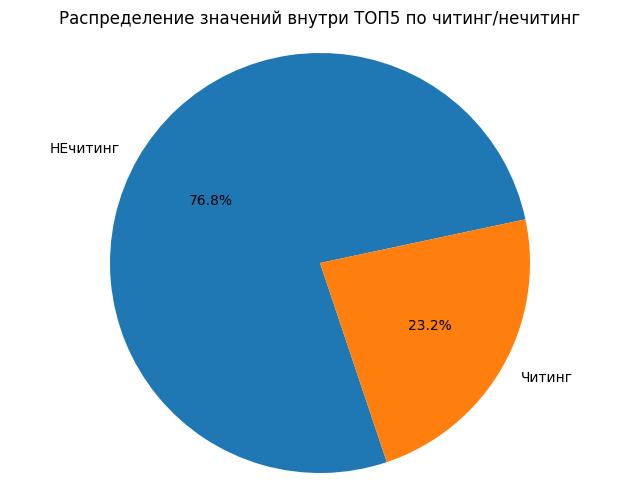

In [12]:
top_5_sum=merge_cheat['count'].sum()
others_sum=merge_cheat['cheating'].sum()
# Объединение данных для круговой диаграммы
pie_data = {'Group': ['НЕчитинг', 'Читинг'],
            'Sum': [top_5_sum-others_sum, others_sum]}
pie_df = pd.DataFrame(pie_data)

# Рисуем круговую диаграмму
plt.figure(figsize=(8, 6))
plt.pie(pie_df['Sum'], labels=pie_df['Group'], autopct='%1.1f%%', startangle=12)
plt.title('Распределение значений внутри ТОП5 по читинг/нечитинг')
plt.axis('equal')
plt.show()

ОК, видим, что представленный датафрейм из топ5 так же не является сбалансированным. Напомню, что мы договорились считать сбалансированным df в пропорции 50/50.

Проверим сколько надо добавить в каждой специализации примеров до 50%. Для этого в каждую специализацию необходимо добавить 

x=count-2cheating 

Просто поверьте [count + x = 2(cheating+x)]

In [13]:
merge_cheat['plus']=merge_cheat['count']-(2*merge_cheat['cheating'])
merge_cheat

,matrix_name,count,cheating,percent,plus
0,DE+Hadoop,806,159,19.73,488
1,DA+Hadoop,433,176,40.65,81
2,QAEngineer,423,83,19.62,257
3,Java,165,13,7.88,139
4,React,153,28,18.30,97


In [14]:
#прилично надо добавить данных
print('Всего надо добавить'
      , sum(merge_cheat['plus'])
      , 'строк c читингом, при условии, что всего имеем'
      , sum(merge_cheat['count'])
      , 'строк' )

Всего надо добавить 1062 строк c читингом, при условии, что всего имеем 1980 строк


## ВЫВОД
1. Существующий датафрейм несбалансирован, НЕчитинг/читинг составляет 77,5/22,5
2. Отобранные строки из ТОП 5 по количеству специализаций (80,1%), находятся примерно в таких же пропорциях 76,8/23,2
3. Наполнить существующий датасет строками с читингом, для сбалансированности (50/50) - добавить еще 1062 строки, т.е. увеличить исследуемый датасет на 53,7%
4. Следует отметить, что внутри распределения специализаций так же наблюдается несбалансированность - специализации распределяются по трем группам:
    - DE+Hadoop	(806)- 40.7%
    - DA+Hadoop (433) + QAEngineer (423) - 43.2%
    - Java (165) + React (153) - 16.1%

    Следовательно существует выраженный перекос в специализацию DE+Hadoop

# 2. Обработка

## 2.1 Исходный файл, длина текстовых составляющих

In [15]:
def flatten_and_join(lst):
    # Рекурсивная функция для объединения вложенных списков в строку
    flattened = []
    for item in lst:
        if isinstance(item, list):
            flattened.extend(flatten_and_join(item))
        else:
            flattened.append(str(item))
    return ' '.join(flattened)

In [16]:
#добавим в исходный data столбцы ['text'] и ['len_text'] с текстом
#и значением длины представленного текста
data.loc[:, 'category_parts_ex']= data['category_parts'].apply(lambda x: flatten_and_join(x))
data.loc[:, 'sub_category_parts_ex']= data['sub_category_parts'].apply(lambda x: flatten_and_join(x))
data.loc[:, 'theme_parts_ex']= data['theme_parts'].apply(lambda x: flatten_and_join(x))
data.loc[:, 'text']= data['transcript_parts'].apply(lambda x: flatten_and_join(x))

data['len_text']=data['text'].apply(len)

In [17]:
data.head()

,transcript_parts,category_parts,sub_category_parts,theme_parts,matrix_name,matrix_language,cheating_percent,cheating,answer_length,answer_length_tokens,cheating_20%,category_parts_ex,sub_category_parts_ex,theme_parts_ex,text,len_text
1206,[interviewer: Что такое Apache Spark и какие е...,[Hadoop],[Spark],"[Spark Core, Spark SQL, Spark Streaming]",DE+Hadoop,ru,0.0,0,"[[1234, 1292, 1788]]","[[451, 241, 670]]",0,Hadoop,Spark,"Spark Core, Spark SQL, Spark Streaming",interviewer: Что такое Apache Spark и какие ег...,4601
1987,[interviewer: Что такое тестирование?\ntrainee...,[QA Engineer],[Теория тестирования],[Основные понятия],QAEngineer,ru,0.0,0,"[[0, 0, 0]]","[[0, 0, 0]]",0,QA Engineer,Теория тестирования,Основные понятия,interviewer: Что такое тестирование?\ntrainee:...,168
2133,[interviewer: Explain the concept of an algori...,[Java],[ALGORITHMS AND DATA STRUCTURES],[Algorithms],Java,en,0.0,0,"[[776, 473, 817]]","[[145, 99, 177]]",0,Java,ALGORITHMS AND DATA STRUCTURES,Algorithms,interviewer: Explain the concept of an algorit...,2452
1778,[interviewer: Что такое Apache Kafka и для чег...,"[Apache Kafka / Apache Airflow, Apache Kafka /...","[Введение в Apache Kafka, Введение в Apache Ka...","[Архитектура Apache Kafka и её компоненты, Осн...",DE+Hadoop,ru,0.0,0,"[[0, 4, 0], [0, 0, 0]]","[[0, 2, 0], [0, 0, 0]]",0,Apache Kafka / Apache Airflow Apache Kafka / A...,Введение в Apache Kafka Введение в Apache Kafka,Архитектура Apache Kafka и её компоненты Основ...,interviewer: Что такое Apache Kafka и для чего...,573
240,[interviewer: Что такое пользовательская истор...,"[Технические знания по BA, QA, Design, Техниче...","[BA, BA, BA, BA, BA, BA, BA, QA, QA, QA, QA, Q...","[Работа с требованиями, Критерии подготовленно...",PM,ru,0.0,0,"[[440, 580, 570], [467, 555, 419], [1442, 707,...","[[167, 233, 224], [186, 246, 170], [573, 298, ...",0,"Технические знания по BA, QA, Design Техническ...",BA BA BA BA BA BA BA QA QA QA QA QA QA QA Desi...,Работа с требованиями Критерии подготовленност...,interviewer: Что такое пользовательская истори...,43327


Проанализируем, как распределяется длина текста ответов

In [18]:
data['len_text'].describe()

count     2472.000000
mean      5421.718042
std       7954.740924
min        168.000000
25%       1252.000000
50%       2561.000000
75%       5892.500000
max      99369.000000
Name: len_text, dtype: float64

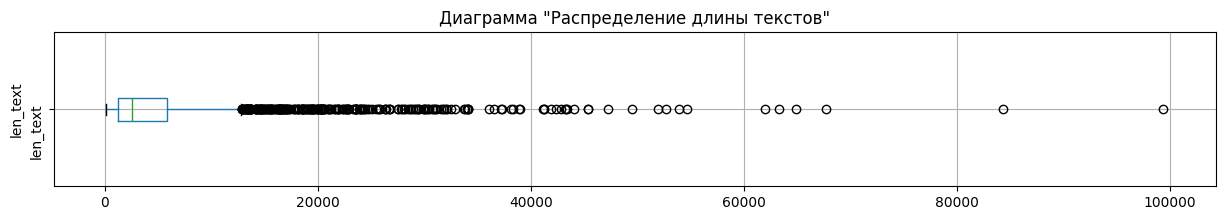

In [19]:
data.boxplot(column=['len_text'], 
                        vert = False, 
                        figsize = (15, 2), 
                        rot = 90)
plt.title('Диаграмма "Распределение длины текстов"')
plt.ylabel('len_text')
plt.show()

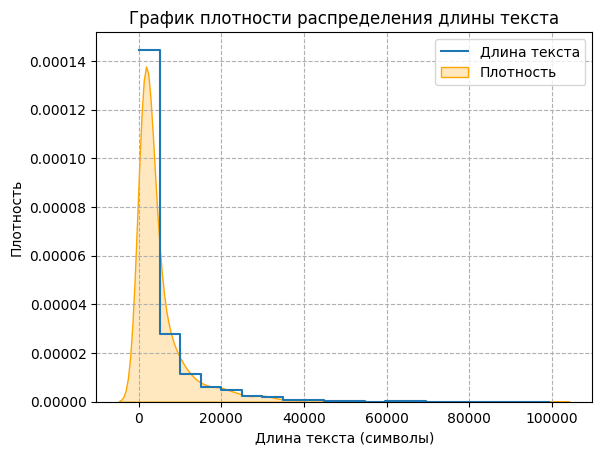

In [20]:
# Строим гистограмму и график плотности ядра
sns.histplot(data=data, x='len_text', 
             bins=20, stat='density', 
             element='step', fill=False,  label='Длина текста')

sns.kdeplot(data=data, 
             x='len_text', 
             fill=True, 
             color='orange', 
             label='Плотность')


plt.title('График плотности распределения длины текста')
plt.xlabel('Длина текста (символы)')
plt.ylabel('Плотность')
plt.grid(True, linestyle='--')
plt.legend()
plt.show()

### Вывод по 2.1
**Вывод по всему фрейму**
1. Большое стандартное отклонение:
    - стандартное отклонение (7954.74) почти в полтора раза больше среднего значения (5421.72). Это свидетельствует о значительной вариации в длине текстов. То есть, тексты в наборе данных сильно различаются по своему объему.
2. Длинные хвосты:
    - максимальное значение (99369 символов) значительно превышает медиану (2561 символ) и среднее значение (5421.72). Это говорит о наличии длинных текстов в наборе данных, которые существенно влияют на общую статистику.
3. Неравномерное распределение:
    - разница между первым квартилем (1252 символа) и третьим квартилем (5892.5 символов) велика. Это указывает на неравномерное распределение длины текстов: значительная часть текстов короткая, но есть и длинные исключения.
4. Нормальность распределения:
    - исходя из разницы между средним и медианой, можно предположить, что распределение длины текста скорее асимметрично (с правым длинным хвостом), нежели симметрично нормальное. Это значит, что короткие тексты встречаются чаще, чем длинные.
    
Исходя из полученного боксплота, графиков плотности и распределения длины текста, можно прогнозировать, что в общем случае **длина ответа колеблется в интервале до 1750 символов** - меньше мединанного значение, т.е очень короткие и емкие ответы

## 2.2 Анализ текстов из Топ5

Проанализируем, как меняется длина текста в ТОП-5

In [21]:
#выделим в data_top5 только те строки, специализации которых совпадают со специализациями из ТОП5 - merge_cheat

data_top5=data[data['matrix_name'].isin(merge_cheat['matrix_name'])]
data_top5.head()

,transcript_parts,category_parts,sub_category_parts,theme_parts,matrix_name,matrix_language,cheating_percent,cheating,answer_length,answer_length_tokens,cheating_20%,category_parts_ex,sub_category_parts_ex,theme_parts_ex,text,len_text
1206,[interviewer: Что такое Apache Spark и какие е...,[Hadoop],[Spark],"[Spark Core, Spark SQL, Spark Streaming]",DE+Hadoop,ru,0.0,0,"[[1234, 1292, 1788]]","[[451, 241, 670]]",0,Hadoop,Spark,"Spark Core, Spark SQL, Spark Streaming",interviewer: Что такое Apache Spark и какие ег...,4601
1987,[interviewer: Что такое тестирование?\ntrainee...,[QA Engineer],[Теория тестирования],[Основные понятия],QAEngineer,ru,0.0,0,"[[0, 0, 0]]","[[0, 0, 0]]",0,QA Engineer,Теория тестирования,Основные понятия,interviewer: Что такое тестирование?\ntrainee:...,168
2133,[interviewer: Explain the concept of an algori...,[Java],[ALGORITHMS AND DATA STRUCTURES],[Algorithms],Java,en,0.0,0,"[[776, 473, 817]]","[[145, 99, 177]]",0,Java,ALGORITHMS AND DATA STRUCTURES,Algorithms,interviewer: Explain the concept of an algorit...,2452
1778,[interviewer: Что такое Apache Kafka и для чег...,"[Apache Kafka / Apache Airflow, Apache Kafka /...","[Введение в Apache Kafka, Введение в Apache Ka...","[Архитектура Apache Kafka и её компоненты, Осн...",DE+Hadoop,ru,0.0,0,"[[0, 4, 0], [0, 0, 0]]","[[0, 2, 0], [0, 0, 0]]",0,Apache Kafka / Apache Airflow Apache Kafka / A...,Введение в Apache Kafka Введение в Apache Kafka,Архитектура Apache Kafka и её компоненты Основ...,interviewer: Что такое Apache Kafka и для чего...,573
1650,[interviewer: Explain the difference between a...,"[Java, Java, Java, Java, Java, Java, Java, Jav...","[ALGORITHMS AND DATA STRUCTURES, CODE QUALITY,...","[Algorithms, Core principles, Version control ...",Java,en,0.0,0,"[[815, 941, 596], [732, 526, 640], [415, 762, ...","[[174, 185, 116], [131, 103, 135], [95, 176, 1...",0,Java Java Java Java Java Java Java Java Java,ALGORITHMS AND DATA STRUCTURES CODE QUALITY BA...,Algorithms Core principles Version control sys...,interviewer: Explain the difference between a ...,26695


In [22]:
data_top5['len_text'].describe()

count     1980.000000
mean      5436.112626
std       8212.991935
min        168.000000
25%       1180.000000
50%       2532.000000
75%       5878.750000
max      99369.000000
Name: len_text, dtype: float64

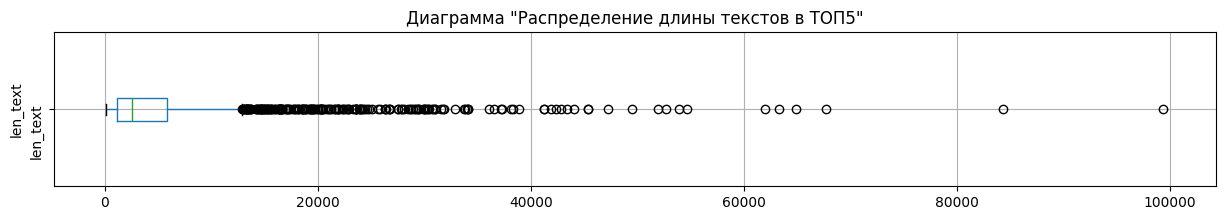

In [23]:
data_top5.boxplot(column=['len_text'], 
                        vert = False, 
                        figsize = (15, 2), 
                        rot = 90)
plt.title('Диаграмма "Распределение длины текстов в ТОП5"')
plt.ylabel('len_text')
plt.show()

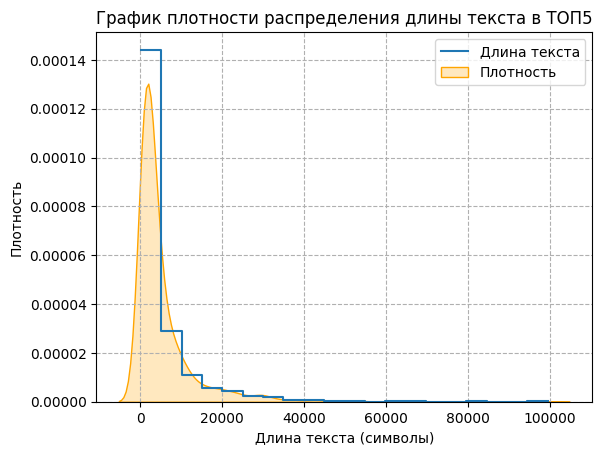

In [24]:
# Строим гистограмму и график плотности ядра
sns.histplot(data=data_top5, x='len_text', 
             bins=20, stat='density', 
             element='step', fill=False,  label='Длина текста')

sns.kdeplot(data=data_top5, x='len_text', 
             fill=True, color='orange', label='Плотность')


plt.title('График плотности распределения длины текста в ТОП5')
plt.xlabel('Длина текста (символы)')
plt.ylabel('Плотность')
plt.grid(True, linestyle='--')
plt.legend()
plt.show()

### Вывод по 2.2

Количественно данные по ТОП5 совпадают с данными по всему датафрейму

## 2.3 Анализ текстов из ТОП5 с читингом

Проведем такой же анализ среди ТОП5-текстов с пометкой читинг

Соберем сначала датафрейм, состоящий из текстов из ТОП5 с пометкой читинг

In [25]:
data_top5_cheating=data_top5[data_top5['cheating_20%']==1]
data_top5_cheating.head()

,transcript_parts,category_parts,sub_category_parts,theme_parts,matrix_name,matrix_language,cheating_percent,cheating,answer_length,answer_length_tokens,cheating_20%,category_parts_ex,sub_category_parts_ex,theme_parts_ex,text,len_text
1371,[interviewer: Что такое Apache Airflow и для ч...,[Apache Kafka / Apache Airflow],[Основы Apache Airflow],[Введение в Apache Airflow: Архитектура и осно...,DE+Hadoop,ru,76.540332,1,"[[1222, 1582, 1600]]","[[479, 572, 601]]",1,Apache Kafka / Apache Airflow,Основы Apache Airflow,Введение в Apache Airflow: Архитектура и основ...,interviewer: Что такое Apache Airflow и для че...,4730
3105,[interviewer: Что такое Agile?\ntrainee: Agile...,[QA Engineer],[Теория тестирования],"[Agile (Scrum, Kanban, XP, etc.)]",QAEngineer,ru,69.038353,1,"[[149, 70, 551]]","[[60, 28, 220]]",1,QA Engineer,Теория тестирования,"Agile (Scrum, Kanban, XP, etc.)",interviewer: Что такое Agile?\ntrainee: Agile ...,956
644,[interviewer: Что такое пропущенные данные и к...,"[Методы инженерии и анализа данных, Методы инж...","[Профилирование и анализ данных, Профилировани...",[Очистка и подготовка данных: Методы и техники...,DA+Hadoop,ru,94.201726,1,"[[1507, 2668, 2211], [1492, 1567, 2878]]","[[585, 1033, 436], [555, 304, 1089]]",1,Методы инженерии и анализа данных Методы инжен...,Профилирование и анализ данных Профилирование ...,Очистка и подготовка данных: Методы и техники ...,interviewer: Что такое пропущенные данные и ка...,12918
2700,[interviewer: Какие существуют типы таблиц в G...,"[GreenPlum, GreenPlum, GreenPlum]","[Основы работы с GreenPlum, Основы работы с Gr...","[Типы таблиц в GreenPlum, Виды распределения д...",DE+Hadoop,ru,88.513116,1,"[[879, 536, 903], [441, 826, 934], [544, 1111,...","[[305, 198, 350], [177, 309, 328], [199, 411, ...",1,GreenPlum GreenPlum GreenPlum,Основы работы с GreenPlum Основы работы с Gree...,Типы таблиц в GreenPlum Виды распределения дан...,interviewer: Какие существуют типы таблиц в Gr...,7555
1914,[interviewer: Что такое Apache Airflow и для ч...,"[Apache Kafka / Apache Airflow, Apache Kafka /...","[Основы Apache Airflow, ETL / ELT с использова...",[Введение в Apache Airflow: Архитектура и осно...,DE+Hadoop,ru,46.198842,1,"[[889, 574, 1726], [969, 718, 1431], [1138, 13...","[[338, 214, 677], [352, 259, 562], [407, 514, ...",1,Apache Kafka / Apache Airflow Apache Kafka / A...,Основы Apache Airflow ETL / ELT с использовани...,Введение в Apache Airflow: Архитектура и основ...,interviewer: Что такое Apache Airflow и для че...,54644


In [26]:
data_top5_cheating['len_text'].describe()

count      459.000000
mean      6421.601307
std       9225.604453
min        168.000000
25%       1350.000000
50%       3475.000000
75%       7711.500000
max      99369.000000
Name: len_text, dtype: float64

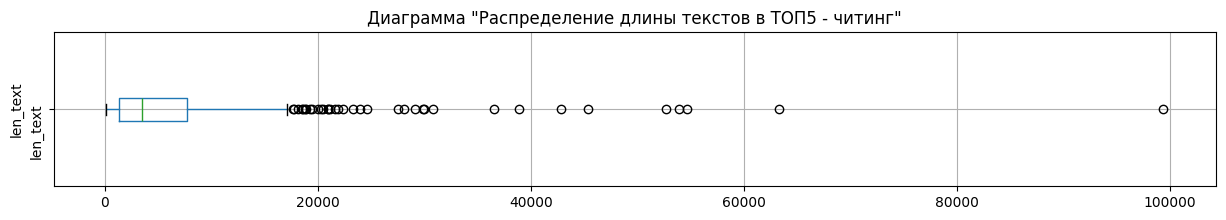

In [27]:
data_top5_cheating.boxplot(column=['len_text'], 
                        vert = False, 
                        figsize = (15, 2), 
                        rot = 90)
plt.title('Диаграмма "Распределение длины текстов в ТОП5 - читинг"')
plt.ylabel('len_text')
plt.show()

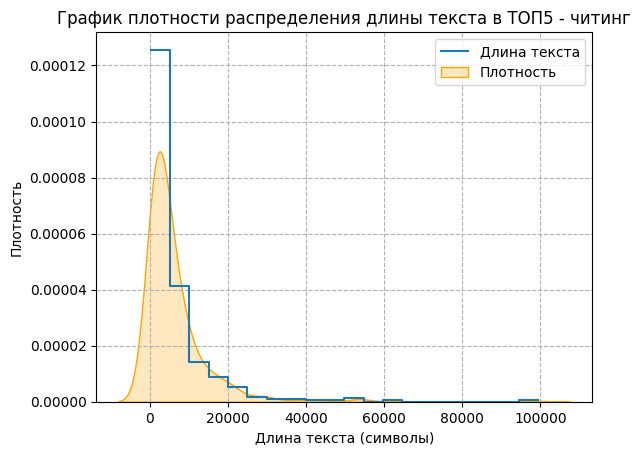

In [28]:
# Строим гистограмму и график плотности ядра
sns.histplot(data=data_top5_cheating, x='len_text', 
             bins=20, stat='density', 
             element='step', fill=False,  label='Длина текста')

sns.kdeplot(data=data_top5_cheating, x='len_text', 
             fill=True, color='orange', label='Плотность')


plt.title('График плотности распределения длины текста в ТОП5 - читинг')
plt.xlabel('Длина текста (символы)')
plt.ylabel('Плотность')
plt.grid(True, linestyle='--')
plt.legend()
plt.show()

### Вывод по 2.3

Видим что, как и ранее все тексты сосредоточены в левой половине, несколько длиннее, чем тексты в целом - до 2000 символов

## Вывод по 2

1. Добавленные тексты, например, сгенерированные ИИ-ботами, либо находящиеся в свободном доступе могут вполне содержат до 2000 символов.
2. Такое количество емких ответов позволяет сгенерить необходимое количество текстов для сбалансированности исходного датафрейма с строками из ТОП5
3. Такие сгенерированные ответы можно считать читингом

# 3. Модель 1

In [84]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

def extract_features(texts, matrix, categories, sub_categories, themes, languages):
    features = []
    
    # Векторизатор для категориальных признаков
    matrix_vectorizer = TfidfVectorizer()
    category_vectorizer = TfidfVectorizer()
    sub_category_vectorizer = TfidfVectorizer()
    theme_vectorizer = TfidfVectorizer()
    language_vectorizer = TfidfVectorizer()
    
    matrix_features=matrix_vectorizer.fit_transform(matrix)
    category_features = category_vectorizer.fit_transform(categories)
    sub_category_features = sub_category_vectorizer.fit_transform(sub_categories)
    theme_features = theme_vectorizer.fit_transform(themes)
    language_features = language_vectorizer.fit_transform(languages)

    # Обрабатываем тексты через spaCy батчами
    docs = list(nlp.pipe(texts, disable=["ner", "textcat"]))
    
    for i, doc in enumerate(docs):
        words = [token.text.lower() for token in doc if token.is_alpha]
        sentences = sent_tokenize(texts[i])
        
        # 1️⃣ Сложность текста
        avg_sentence_length = np.mean([len(sent.split()) for sent in sentences]) if sentences else 0
        avg_word_length = np.mean([len(word) for word in words]) if words else 0
        type_token_ratio = len(set(words)) / len(words) if words else 0
        long_words_ratio = sum(1 for word in words if len(word) > 7) / len(words) if words else 0
        
        # 2️⃣ Частотные характеристики
        text_chars = Counter(texts[i])
        total_chars = len(texts[i])
        special_symbols_ratio = sum(text_chars[c] for c in special_symbols) / total_chars if total_chars else 0
        unique_letters_ratio = len(set(texts[i])) / total_chars if total_chars else 0
        uppercase_ratio = sum(1 for c in texts[i] if c.isupper()) / total_chars if total_chars else 0
        latin_ratio = sum(1 for c in texts[i] if re.match(r'[a-zA-Z]', c)) / total_chars if total_chars else 0
        
        # 3️⃣ Функциональные слова
        stop_words_ratio = sum(1 for word in words if word in stop_words) / len(words) if words else 0
        
        # 4️⃣ Части речи
        pos_counts = Counter(token.pos_ for token in doc)
        total_tokens = len(doc)
        pos_ratios = {pos: pos_counts.get(pos, 0) / total_tokens if total_tokens else 0
                      for pos in ['NOUN', 'VERB', 'ADJ', 'ADV', 'PRON', 'CCONJ', 'SCONJ', 'ADP', 'AUX']}
        
        # 5️⃣ Синтаксическая сложность
        tree_depths = [token.i - token.head.i for token in doc if token.dep_ != 'ROOT']
        max_depth = max(tree_depths, default=0)
        avg_depth = np.mean(tree_depths) if tree_depths else 0
        
        # Собираем все признаки
        text_features = [
            avg_sentence_length, avg_word_length, type_token_ratio, long_words_ratio,
            special_symbols_ratio, unique_letters_ratio, uppercase_ratio, latin_ratio,
            stop_words_ratio, max_depth, avg_depth,
            pos_ratios['NOUN'], pos_ratios['VERB'], pos_ratios['ADJ'], pos_ratios['ADV'],
            pos_ratios['PRON'], pos_ratios['CCONJ'], pos_ratios['SCONJ'], pos_ratios['ADP'],
            pos_ratios['AUX']
        ]
        features.append(text_features)
    
    # Преобразуем в DataFrame
    feature_names = [
        "avg_sentence_length", "avg_word_length", "type_token_ratio", "long_words_ratio",  
        "special_symbols_ratio", "unique_letters_ratio", "uppercase_ratio", "latin_ratio",
        "stop_words_ratio", "max_depth", "avg_depth",
        "NOUN_ratio", "VERB_ratio", "ADJ_ratio", "ADV_ratio",
        "PRON_ratio", "CCONJ_ratio", "SCONJ_ratio", "ADP_ratio", "AUX_ratio"
    ]
    
    text_features_df = pd.DataFrame(features, columns=feature_names)
    
    # Объединяем текстовые и категориальные признаки
    final_features = hstack([
        text_features_df.values, matrix_features, category_features, sub_category_features, theme_features, language_features
    ])
    
    return final_features



In [85]:
data.head()

,transcript_parts,category_parts,sub_category_parts,theme_parts,matrix_name,matrix_language,cheating_percent,cheating,answer_length,answer_length_tokens,cheating_20%,category_parts_ex,sub_category_parts_ex,theme_parts_ex,text,len_text,count_cp,count_scp,count_tp,answer
1206,[interviewer: Что такое Apache Spark и какие е...,[Hadoop],[Spark],"[Spark Core, Spark SQL, Spark Streaming]",DE+Hadoop,ru,0.0,0,"[[1234, 1292, 1788]]","[[451, 241, 670]]",0,Hadoop,Spark,"Spark Core, Spark SQL, Spark Streaming",interviewer: Что такое Apache Spark и какие ег...,4601,1,1,1,3
1987,[interviewer: Что такое тестирование?\ntrainee...,[QA Engineer],[Теория тестирования],[Основные понятия],QAEngineer,ru,0.0,0,"[[0, 0, 0]]","[[0, 0, 0]]",0,QA Engineer,Теория тестирования,Основные понятия,interviewer: Что такое тестирование?\ntrainee:...,168,1,1,1,3
2133,[interviewer: Explain the concept of an algori...,[Java],[ALGORITHMS AND DATA STRUCTURES],[Algorithms],Java,en,0.0,0,"[[776, 473, 817]]","[[145, 99, 177]]",0,Java,ALGORITHMS AND DATA STRUCTURES,Algorithms,interviewer: Explain the concept of an algorit...,2452,1,1,1,3
1778,[interviewer: Что такое Apache Kafka и для чег...,"[Apache Kafka / Apache Airflow, Apache Kafka /...","[Введение в Apache Kafka, Введение в Apache Ka...","[Архитектура Apache Kafka и её компоненты, Осн...",DE+Hadoop,ru,0.0,0,"[[0, 4, 0], [0, 0, 0]]","[[0, 2, 0], [0, 0, 0]]",0,Apache Kafka / Apache Airflow Apache Kafka / A...,Введение в Apache Kafka Введение в Apache Kafka,Архитектура Apache Kafka и её компоненты Основ...,interviewer: Что такое Apache Kafka и для чего...,573,2,2,2,6
240,[interviewer: Что такое пользовательская истор...,"[Технические знания по BA, QA, Design, Техниче...","[BA, BA, BA, BA, BA, BA, BA, QA, QA, QA, QA, Q...","[Работа с требованиями, Критерии подготовленно...",PM,ru,0.0,0,"[[440, 580, 570], [467, 555, 419], [1442, 707,...","[[167, 233, 224], [186, 246, 170], [573, 298, ...",0,"Технические знания по BA, QA, Design Техническ...",BA BA BA BA BA BA BA QA QA QA QA QA QA QA Desi...,Работа с требованиями Критерии подготовленност...,interviewer: Что такое пользовательская истори...,43327,16,16,16,48


In [86]:
data_exp=data[['matrix_name',
            'category_parts_ex',
            'sub_category_parts_ex',
            'theme_parts_ex',
            'text',
            'matrix_language',
            'cheating_20%'
            ]].reset_index(drop=True)

In [87]:
data_exp.head()

,matrix_name,category_parts_ex,sub_category_parts_ex,theme_parts_ex,text,matrix_language,cheating_20%
0,DE+Hadoop,Hadoop,Spark,"Spark Core, Spark SQL, Spark Streaming",interviewer: Что такое Apache Spark и какие ег...,ru,0
1,QAEngineer,QA Engineer,Теория тестирования,Основные понятия,interviewer: Что такое тестирование?\ntrainee:...,ru,0
2,Java,Java,ALGORITHMS AND DATA STRUCTURES,Algorithms,interviewer: Explain the concept of an algorit...,en,0
3,DE+Hadoop,Apache Kafka / Apache Airflow Apache Kafka / A...,Введение в Apache Kafka Введение в Apache Kafka,Архитектура Apache Kafka и её компоненты Основ...,interviewer: Что такое Apache Kafka и для чего...,ru,0
4,PM,"Технические знания по BA, QA, Design Техническ...",BA BA BA BA BA BA BA QA QA QA QA QA QA QA Desi...,Работа с требованиями Критерии подготовленност...,interviewer: Что такое пользовательская истори...,ru,0


In [88]:
# Извлекаем признаки и добавляем их в data_exp
features_df = extract_features(
    data_exp['text'].tolist(),
    data_exp['matrix_name'].tolist(),
    data_exp['category_parts_ex'].tolist(),
    data_exp['sub_category_parts_ex'].tolist(),
    data_exp['theme_parts_ex'].tolist(),
    data_exp['matrix_language'].tolist()
)
data_exp = pd.concat([data_exp, pd.DataFrame(features_df.toarray())], axis=1).reset_index(drop=True)

In [83]:
data_exp.head(20)

,matrix,category,sub_category,theme_parts,text_new,matrix_language,cheating_20%,0
0,DE+Hadoop,Hadoop,Spark,"Spark Core, Spark SQL, Spark Streaming",interviewer: Что такое Apache Spark и какие ег...,ru,0,<Compressed Sparse Row sparse matrix of dtype ...
1,DE+Hadoop,Hadoop,Spark,"Spark Core, Spark SQL, Spark Streaming",interviewer: Как можно оптимизировать запросы ...,ru,0,<Compressed Sparse Row sparse matrix of dtype ...
2,DE+Hadoop,Hadoop,Spark,"Spark Core, Spark SQL, Spark Streaming",interviewer: Каковы методы оптимизации шаффлин...,ru,0,<Compressed Sparse Row sparse matrix of dtype ...
3,QAEngineer,QA Engineer,Теория тестирования,Основные понятия,interviewer: Что такое тестирование?\ntrainee:,ru,0,<Compressed Sparse Row sparse matrix of dtype ...
4,QAEngineer,QA Engineer,Теория тестирования,Основные понятия,interviewer: Почему тестирование необходимо?\n...,ru,0,<Compressed Sparse Row sparse matrix of dtype ...
5,QAEngineer,QA Engineer,Теория тестирования,Основные понятия,"interviewer: Раскройте понятия QA, QC и тестир...",ru,0,<Compressed Sparse Row sparse matrix of dtype ...
6,Java,Java,ALGORITHMS AND DATA STRUCTURES,Algorithms,interviewer: Explain the concept of an algorit...,en,0,<Compressed Sparse Row sparse matrix of dtype ...
7,Java,Java,ALGORITHMS AND DATA STRUCTURES,Algorithms,interviewer: Describe the Quick Sort algorithm...,en,0,<Compressed Sparse Row sparse matrix of dtype ...
8,Java,Java,ALGORITHMS AND DATA STRUCTURES,Algorithms,interviewer: Discuss how the choice of data st...,en,0,<Compressed Sparse Row sparse matrix of dtype ...
9,DE+Hadoop,Apache Kafka / Apache Airflow,Введение в Apache Kafka,Архитектура Apache Kafka и её компоненты,interviewer: Что такое Apache Kafka и для чего...,ru,0,<Compressed Sparse Row sparse matrix of dtype ...


In [35]:
data_exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2472 entries, 0 to 2471
Columns: 1810 entries, matrix_name to 1802
dtypes: float64(1803), int64(1), object(6)
memory usage: 34.1+ MB


In [36]:
# Разделяем данные на признаки (X) и целевую переменную (y)
X = extract_features(
    data_exp['text'].tolist(),
     data_exp['matrix_name'].tolist(),
    data_exp['category_parts_ex'].tolist(),
    data_exp['sub_category_parts_ex'].tolist(),
    data_exp['theme_parts_ex'].tolist(),
    data_exp['matrix_language'].tolist()
)
y = data_exp['cheating_20%']

# Разделяем данные на обучающую и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [37]:
from imblearn.ensemble import BalancedRandomForestClassifier
# Преобразуем разреженную матрицу в плотную
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

# Обучение модели
rf = RandomForestClassifier(n_estimators=300, random_state=42, class_weight={0: 1, 1: 1.5}, 
                            max_depth=30, min_samples_leaf=2)

rf.fit(X_train_dense, y_train)

# Предсказание вероятностей
y_proba = rf.predict_proba(X_test_dense)[:, 1]  # Берем вероятности для класса "1"

# Предсказание с изменённым порогом
threshold = 0.42  # Можно попробовать 0.45-0.48
y_pred_adj = (y_proba > threshold).astype(int)


Accuracy: 0.8404
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       383
           1       0.73      0.46      0.57       112

    accuracy                           0.84       495
   macro avg       0.80      0.71      0.74       495
weighted avg       0.83      0.84      0.83       495



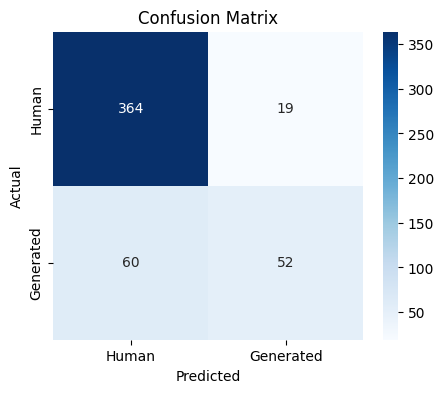

In [38]:
# Оценка модели
accuracy = accuracy_score(y_test, y_pred_adj)
print(f"Accuracy: {accuracy:.4f}")

print("Classification Report:")
print(classification_report(y_test, y_pred_adj))

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred_adj)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'Generated'], yticklabels=['Human', 'Generated'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Вывод по Модели 1

1. **Анализ метрик**
* Класс 0 (человеческие тексты)
    - Precision = 0.86 (14% из предсказанных "0" ошибочны)
    - Recall = 0.95 (почти все реальные "0" найдены)
    - F1-score = 0.90 (высокий баланс)
* Класс 1 (сгенерированные тексты)
    - Precision = 0.73 (27% ложных срабатываний)
    - Recall = 0.46 (теряем 54% реальных "1")
    - F1-score = 0.57 (слабый баланс)

2. **Проблемы и улучшения**
* Плохой recall для класса 1 → Классификатор плохо ловит сгенерированные тексты
    - Решение: Увеличить штраф за FN (например, настроить class_weight={0: 1, 1: 2} в RandomForest)
* Дисбаланс классов (383 vs 112) → Модель учится лучше распознавать "0"
    - Решение: Попробовать SMOTE или Random Undersampling
* Возможно, переобучение на класс 0 → Random Forest может слишком запоминать
    - Решение: Попробовать уменьшить max_depth или n_estimators

# 4. Модель 2

В "Моделе 2" разделим каждую запись экзамена на отдельные строки "вопрос-ответ" с сохранением категорий, подкатегорий и специализаций.

Т.к. текстовая составляющая имеет разные значения, т.е. где-то в рамках экзамена могут быть заданы 3 вопроса, а где-то 33. Каждый вопрос начинается с пометки interviewer. Например, в строке 240 "interviewer" встречается 48 раз, т.е. в записи этого экзамена задано 48 вопросов и получено 48 ответов.

Проверим, что количество вопросов и ответов бъется с количеством спеицализаций, категорий и подкатегорий. Это необходимо для дальнейшего проведения обучения модели

## 4.1 Разделение Модели 2 на "вопрос-ответ"

In [41]:
# Это посчитали сколько категорий, подкатегорий и тем содержатся в ответах
data['count_cp']=data['category_parts'].apply(len)
data['count_scp']=data['sub_category_parts'].apply(len)
data['count_tp']=data['theme_parts'].apply(len)
data[['text',
      'matrix_name',
      'category_parts',
      'count_cp',
      'sub_category_parts',
      'count_scp',
      'theme_parts',
        'count_tp']]

# Далее сделаем проверку условия равенства значений в столбцах
mask = ~(data['count_cp'] == data['count_scp']) | ~(data['count_scp'] == data['count_tp'])

# Фильтруем строки, где условие не выполнено
invalid_rows = data[mask]

# Выводим строки, где значения отличаются
if len(invalid_rows) > 0:
    print("Строки, где значения в столбцах разные:")
    print(invalid_rows)
else:
    print("Все строки соответствуют условию.")  

Все строки соответствуют условию.


In [42]:
# Проверим, что на каждое количество theme_parts приходится ровно по три ответа
# ответы берем, как выбранные из text количество interviewer
data['answer'] = data['text'].apply(lambda x: x.count('interviewer'))


# Далее сделаем проверку условия равенства значений в столбцах
mask_ans = ~(data['answer'] == 3* data['count_scp'])
# Фильтруем строки, где условие не выполнено
invalid_ans = data[mask_ans]

# Выводим строки, где значения отличаются
if len(invalid_ans) > 0:
    print("Строки, где количество ответов меньше, чем в 3 раза, чем количество тем вопросов:")
    row_numbers = invalid_ans.index.to_list()
    print(row_numbers)
    print("Всего таких строк",len(invalid_ans) )
else:
    print("Все строки соответствуют условию.") 

Строки, где количество ответов меньше, чем в 3 раза, чем количество тем вопросов:
[874, 1231, 620, 26, 1940, 3054, 24, 23, 20, 3022, 3039, 762, 408, 34, 349, 1681, 1982, 2674, 208, 2146, 2635]
Всего таких строк 21


In [43]:
#собираем df, в котром нет строк из data_5_3
df = data.drop(index=row_numbers).reset_index(drop=True)
df.head()

,transcript_parts,category_parts,sub_category_parts,theme_parts,matrix_name,matrix_language,cheating_percent,cheating,answer_length,answer_length_tokens,cheating_20%,category_parts_ex,sub_category_parts_ex,theme_parts_ex,text,len_text,count_cp,count_scp,count_tp,answer
0,[interviewer: Что такое Apache Spark и какие е...,[Hadoop],[Spark],"[Spark Core, Spark SQL, Spark Streaming]",DE+Hadoop,ru,0.0,0,"[[1234, 1292, 1788]]","[[451, 241, 670]]",0,Hadoop,Spark,"Spark Core, Spark SQL, Spark Streaming",interviewer: Что такое Apache Spark и какие ег...,4601,1,1,1,3
1,[interviewer: Что такое тестирование?\ntrainee...,[QA Engineer],[Теория тестирования],[Основные понятия],QAEngineer,ru,0.0,0,"[[0, 0, 0]]","[[0, 0, 0]]",0,QA Engineer,Теория тестирования,Основные понятия,interviewer: Что такое тестирование?\ntrainee:...,168,1,1,1,3
2,[interviewer: Explain the concept of an algori...,[Java],[ALGORITHMS AND DATA STRUCTURES],[Algorithms],Java,en,0.0,0,"[[776, 473, 817]]","[[145, 99, 177]]",0,Java,ALGORITHMS AND DATA STRUCTURES,Algorithms,interviewer: Explain the concept of an algorit...,2452,1,1,1,3
3,[interviewer: Что такое Apache Kafka и для чег...,"[Apache Kafka / Apache Airflow, Apache Kafka /...","[Введение в Apache Kafka, Введение в Apache Ka...","[Архитектура Apache Kafka и её компоненты, Осн...",DE+Hadoop,ru,0.0,0,"[[0, 4, 0], [0, 0, 0]]","[[0, 2, 0], [0, 0, 0]]",0,Apache Kafka / Apache Airflow Apache Kafka / A...,Введение в Apache Kafka Введение в Apache Kafka,Архитектура Apache Kafka и её компоненты Основ...,interviewer: Что такое Apache Kafka и для чего...,573,2,2,2,6
4,[interviewer: Что такое пользовательская истор...,"[Технические знания по BA, QA, Design, Техниче...","[BA, BA, BA, BA, BA, BA, BA, QA, QA, QA, QA, Q...","[Работа с требованиями, Критерии подготовленно...",PM,ru,0.0,0,"[[440, 580, 570], [467, 555, 419], [1442, 707,...","[[167, 233, 224], [186, 246, 170], [573, 298, ...",0,"Технические знания по BA, QA, Design Техническ...",BA BA BA BA BA BA BA QA QA QA QA QA QA QA Desi...,Работа с требованиями Критерии подготовленност...,interviewer: Что такое пользовательская истори...,43327,16,16,16,48


Разбиваем текст на блоки по interviewer, собираем новый датасет- вопрос из theme_parts / ответ из text

In [44]:
expanded_data = []
expanded_df=[]
def expand_text_and_themes(df):
    expanded_data = []

    for _, row in df.iterrows():
        text_parts = row["text"].split("interviewer")
        text_parts = [part.strip() for part in text_parts]
        text_parts.pop(0) 
        themes = row["theme_parts"]
        sub_category = row["sub_category_parts"]
        category = row["category_parts"]
        matrix = str(row["matrix_name"]),
        matrix_language=str(row["matrix_language"]),
        cheating_20=row['cheating_20%']
        


        # Разбиваем текст на блоки по 3 части и сопоставляем темы
        for i in range(len(text_parts)):
            theme_index = i // 3
            combined_text = "interviewer"+" ".join(text_parts[i:i+1])
            expanded_data.append({
                "matrix": matrix,  # Извлекаем соответствующее значение из матрицы
                "category": category[theme_index],
                "sub_category": sub_category[theme_index],
                "theme_parts": themes[theme_index],
                "text_new": combined_text,
                "matrix_language":matrix_language,
                "cheating_20%":cheating_20
            })

    return pd.DataFrame(expanded_data)

In [45]:
expanded_df = pd.DataFrame(expand_text_and_themes(df))
expanded_df['matrix'] = expanded_df['matrix'].astype(str).str.strip("()").str.strip(",'")
expanded_df['matrix_language'] = expanded_df['matrix_language'].astype(str).str.strip("()").str.strip(",'")

In [46]:
expanded_df.head()

,matrix,category,sub_category,theme_parts,text_new,matrix_language,cheating_20%
0,DE+Hadoop,Hadoop,Spark,"Spark Core, Spark SQL, Spark Streaming",interviewer: Что такое Apache Spark и какие ег...,ru,0
1,DE+Hadoop,Hadoop,Spark,"Spark Core, Spark SQL, Spark Streaming",interviewer: Как можно оптимизировать запросы ...,ru,0
2,DE+Hadoop,Hadoop,Spark,"Spark Core, Spark SQL, Spark Streaming",interviewer: Каковы методы оптимизации шаффлин...,ru,0
3,QAEngineer,QA Engineer,Теория тестирования,Основные понятия,interviewer: Что такое тестирование?\ntrainee:,ru,0
4,QAEngineer,QA Engineer,Теория тестирования,Основные понятия,interviewer: Почему тестирование необходимо?\n...,ru,0


In [47]:
expanded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24936 entries, 0 to 24935
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   matrix           24936 non-null  object
 1   category         24936 non-null  object
 2   sub_category     24936 non-null  object
 3   theme_parts      24936 non-null  object
 4   text_new         24936 non-null  object
 5   matrix_language  24936 non-null  object
 6   cheating_20%     24936 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 1.3+ MB


Таким образом, датафрейм увеличился до 24 936 строк

## 4.2 Обучение Модели 2

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix


# Функция извлечения признаков
def extract_features(texts, matrix, categories, sub_categories, themes, languages):
    features = []
    
    # Векторизаторы для категориальных признаков
    matrix_vectorizer = TfidfVectorizer()
    category_vectorizer = TfidfVectorizer()
    sub_category_vectorizer = TfidfVectorizer()
    theme_vectorizer = TfidfVectorizer()
    language_vectorizer = TfidfVectorizer()
    
    # Векторизуем категориальные признаки
    matrix_features = matrix_vectorizer.fit_transform(matrix)
    category_features = category_vectorizer.fit_transform(categories)
    sub_category_features = sub_category_vectorizer.fit_transform(sub_categories)
    theme_features = theme_vectorizer.fit_transform(themes)
    language_features = language_vectorizer.fit_transform(languages)
    
    # Обрабатываем тексты через spaCy батчами
    docs = list(nlp.pipe(texts, disable=["ner", "textcat"]))
    
    for i, doc in enumerate(docs):
        words = [token.text.lower() for token in doc if token.is_alpha]
        sentences = sent_tokenize(texts[i])
        
        # 1️⃣ Сложность текста
        avg_sentence_length = np.mean([len(sent.split()) for sent in sentences]) if sentences else 0
        avg_word_length = np.mean([len(word) for word in words]) if words else 0
        type_token_ratio = len(set(words)) / len(words) if words else 0
        long_words_ratio = sum(1 for word in words if len(word) > 7) / len(words) if words else 0
        
        # 2️⃣ Частотные характеристики
        text_chars = Counter(texts[i])
        total_chars = len(texts[i])
        special_symbols_ratio = sum(text_chars[c] for c in special_symbols) / total_chars if total_chars else 0
        unique_letters_ratio = len(set(texts[i])) / total_chars if total_chars else 0
        uppercase_ratio = sum(1 for c in texts[i] if c.isupper()) / total_chars if total_chars else 0
        latin_ratio = sum(1 for c in texts[i] if re.match(r'[a-zA-Z]', c)) / total_chars if total_chars else 0
        
        # 3️⃣ Функциональные слова
        stop_words_ratio = sum(1 for word in words if word in stop_words) / len(words) if words else 0
        
        # 4️⃣ Части речи
        pos_counts = Counter(token.pos_ for token in doc)
        total_tokens = len(doc)
        pos_ratios = {pos: pos_counts.get(pos, 0) / total_tokens if total_tokens else 0
                      for pos in ['NOUN', 'VERB', 'ADJ', 'ADV', 'PRON', 'CCONJ', 'SCONJ', 'ADP', 'AUX']}
        
        # 5️⃣ Синтаксическая сложность
        tree_depths = [token.i - token.head.i for token in doc if token.dep_ != 'ROOT']
        max_depth = max(tree_depths, default=0)
        avg_depth = np.mean(tree_depths) if tree_depths else 0
        
        # Собираем все признаки
        text_features = [
            avg_sentence_length, avg_word_length, type_token_ratio, long_words_ratio,
            special_symbols_ratio, unique_letters_ratio, uppercase_ratio, latin_ratio,
            stop_words_ratio, max_depth, avg_depth,
            pos_ratios['NOUN'], pos_ratios['VERB'], pos_ratios['ADJ'], pos_ratios['ADV'],
            pos_ratios['PRON'], pos_ratios['CCONJ'], pos_ratios['SCONJ'], pos_ratios['ADP'],
            pos_ratios['AUX']
        ]
        features.append(text_features)
    
    # Преобразуем признаки текста в DataFrame
    feature_names = [
        "avg_sentence_length", "avg_word_length", "type_token_ratio", "long_words_ratio",  
        "special_symbols_ratio", "unique_letters_ratio", "uppercase_ratio", "latin_ratio",
        "stop_words_ratio", "max_depth", "avg_depth",
        "NOUN_ratio", "VERB_ratio", "ADJ_ratio", "ADV_ratio",
        "PRON_ratio", "CCONJ_ratio", "SCONJ_ratio", "ADP_ratio", "AUX_ratio"
    ]
    
    text_features_df = pd.DataFrame(features, columns=feature_names)

    # 🟢 Преобразуем DataFrame в sparse-формат (для hstack)
    text_features_sparse = csr_matrix(text_features_df.values)

    # Объединяем все признаки
    final_features = hstack([
    csr_matrix(text_features_df),  # Преобразуем DataFrame в sparse-матрицу
    matrix_features, 
    category_features, 
    sub_category_features, 
    theme_features, 
    language_features
])
    
    return final_features

In [49]:
# Извлекаем признаки и добавляем их в data_exp
features_df = extract_features(
    expanded_df['text_new'].tolist(),
    expanded_df['matrix'].tolist(),
    expanded_df['category'].tolist(),
    expanded_df['sub_category'].tolist(),
    expanded_df['theme_parts'].tolist(),
    expanded_df['matrix_language'].tolist()
)

In [50]:
# Преобразуем массив в DataFrame
features_df = pd.DataFrame(features_df)

# Добавляем извлечённые признаки в датафрейм
data_exp = pd.concat([expanded_df, features_df], axis=1).reset_index(drop=True)

In [51]:
data_exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24936 entries, 0 to 24935
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   matrix           24936 non-null  object
 1   category         24936 non-null  object
 2   sub_category     24936 non-null  object
 3   theme_parts      24936 non-null  object
 4   text_new         24936 non-null  object
 5   matrix_language  24936 non-null  object
 6   cheating_20%     24936 non-null  int64 
 7   0                24936 non-null  object
dtypes: int64(1), object(7)
memory usage: 1.5+ MB


In [52]:
# Разделяем данные на признаки (X) и целевую переменную (y)
X = extract_features(
    data_exp['text_new'].tolist(),
    data_exp['matrix'].tolist(),
    data_exp['category'].tolist(),
    data_exp['sub_category'].tolist(),
    data_exp['theme_parts'].tolist(),
    data_exp['matrix_language'].tolist()
)
y = data_exp['cheating_20%']

In [53]:
# Разделяем данные на обучающую и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [54]:
from imblearn.ensemble import BalancedRandomForestClassifier
# Преобразуем разреженную матрицу в плотную
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

In [55]:
# Обучение модели
rf = RandomForestClassifier(n_estimators=300, random_state=42, class_weight={0: 1, 1: 1}, 
                            max_depth=30, min_samples_leaf=2)

rf.fit(X_train_dense, y_train)

# Предсказание вероятностей
y_proba = rf.predict_proba(X_test_dense)[:, 1]  # Берем вероятности для класса "1"

# Предсказание с изменённым порогом
threshold = 0.42  # Можно попробовать 0.45-0.48
y_pred_adj = (y_proba > threshold).astype(int)

Accuracy: 0.8416
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.98      0.91      4025
           1       0.75      0.27      0.40       963

    accuracy                           0.84      4988
   macro avg       0.80      0.62      0.65      4988
weighted avg       0.83      0.84      0.81      4988



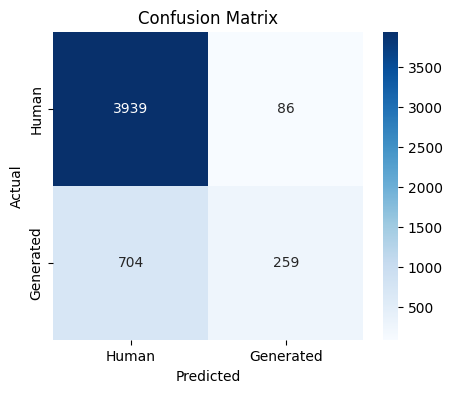

In [56]:
# Оценка модели
accuracy = accuracy_score(y_test, y_pred_adj)
print(f"Accuracy: {accuracy:.4f}")

print("Classification Report:")
print(classification_report(y_test, y_pred_adj))

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred_adj)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'Generated'], yticklabels=['Human', 'Generated'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Вывод по Модели 2

1. **Анализ текущих результатов**:
- Accuracy = 84.16% (но при дисбалансе классов этот показатель не всегда полезен)
___  
* Класс 0 (человеческие тексты)
    - Precision = 0.85 (15% ошибок среди предсказанных "0")
    - Recall = 0.98 (почти все реальные "0" найдены)
    - F1-score = 0.91 (очень хорошо)
___
* Класс 1 (сгенерированные тексты)
    - Precision = 0.75 (25% ложных срабатываний).
    - Recall = 0.27 (теряем 73% реальных "1").
    - F1-score = 0.40 (низкий, проблема с recall).
___
- Macro avg (0.80, 0.62, 0.65) — общий баланс между классами хромает.
___

2. **Основная проблема**: низкий recall для класса 1 (27%) - классификатор хорошо определяет "0", но плохо ловит "1" (сгенерированные тексты)


**Сбалансируем данные по показателю Читинг (1) с помощью алгоритма smote**

# 5. Модель 3
Модель 2 обогатим с помощью алгоритма smote

***SMOTE** (Synthetic Minority Over-sampling Technique) — это метод увеличения количества объектов миноритарного класса (в нашем случае, класса 1 — сгенерированных текстов) путем генерации синтетических примеров вместо простого дублирования существующих данных.*

*Как работает SMOTE?*

- *Берет случайный объект миноритарного класса*
- *Находит его k ближайших соседей (по умолчанию k=5)*
- *Создает новые примеры на отрезке между исходной точкой и случайно выбранным соседом*

In [57]:
expanded_df = pd.DataFrame(expand_text_and_themes(df))
expanded_df['matrix'] = expanded_df['matrix'].astype(str).str.strip("()").str.strip(",'")
expanded_df['matrix_language'] = expanded_df['matrix_language'].astype(str).str.strip("()").str.strip(",'")

In [58]:
# Извлекаем признаки и добавляем их в data_exp
features_df = extract_features(
    expanded_df['text_new'].tolist(),
    expanded_df['matrix'].tolist(),
    expanded_df['category'].tolist(),
    expanded_df['sub_category'].tolist(),
    expanded_df['theme_parts'].tolist(),
    expanded_df['matrix_language'].tolist()
)

In [59]:
# Преобразуем массив в DataFrame
features_df = pd.DataFrame(features_df)
# Добавляем извлечённые признаки в датафрейм
data_exp = pd.concat([expanded_df, features_df], axis=1).reset_index(drop=True)

In [60]:
# Разделяем данные на признаки (X) и целевую переменную (y)
X = extract_features(
    data_exp['text_new'].tolist(),
    data_exp['matrix'].tolist(),
    data_exp['category'].tolist(),
    data_exp['sub_category'].tolist(),
    data_exp['theme_parts'].tolist(),
    data_exp['matrix_language'].tolist()
)
y = data_exp['cheating_20%']

### 5.1 SMOTE(sampling_strategy=1.0)

Этот параметр означает, что в класс 1 уйдет 100% от класса 0 (количество строк с читингом будет равно количеству строк без читинга)

In [61]:
# Настройка параметров SMOTE
smote = SMOTE(k_neighbors=5, sampling_strategy='auto', random_state=42)

# Применение SMOTE
X_resampled, y_resampled = smote.fit_resample(X, y)

# Выводим баланс классов после SMOTE
print("Распределение классов после SMOTE:", Counter(y_resampled))

Распределение классов после SMOTE: Counter({0: 20121, 1: 20121})


In [62]:
# Теперь разделяем сбалансированные данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [63]:
# Преобразуем разреженную матрицу в плотную
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

In [64]:
# Обучение модели
rf = RandomForestClassifier(n_estimators=300, random_state=42, class_weight={0: 1, 1: 1}, 
                            max_depth=30, min_samples_leaf=2)

rf.fit(X_train_dense, y_train)

# Предсказание вероятностей
y_proba = rf.predict_proba(X_test_dense)[:, 1]  # Берем вероятности для класса "1"

# Предсказание с изменённым порогом
threshold = 0.42  # Можно попробовать 0.45-0.48
y_pred_adj = (y_proba > threshold).astype(int)

Accuracy: 0.8697
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.84      0.86      4003
           1       0.85      0.90      0.87      4046

    accuracy                           0.87      8049
   macro avg       0.87      0.87      0.87      8049
weighted avg       0.87      0.87      0.87      8049



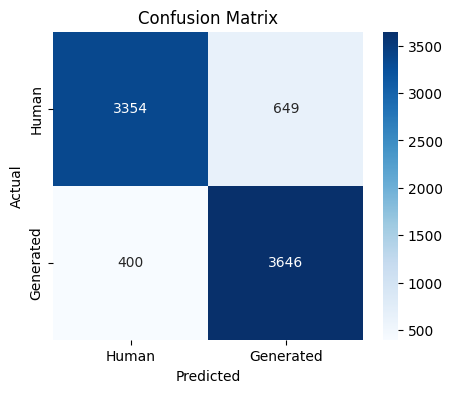

In [65]:
# Оценка модели
accuracy = accuracy_score(y_test, y_pred_adj)
print(f"Accuracy: {accuracy:.4f}")

print("Classification Report:")
print(classification_report(y_test, y_pred_adj))

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred_adj)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'Generated'], yticklabels=['Human', 'Generated'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### 5.2 SMOTE(sampling_strategy=0.4)

Этот параметр означает, что в класс 1 уйдет 40% от класса 0

In [66]:
# Настройка параметров SMOTE
smote = SMOTE(k_neighbors=5, sampling_strategy=0.4, random_state=42)

# Применение SMOTE
X_resampled, y_resampled = smote.fit_resample(X, y)

# Выводим баланс классов после SMOTE
print("Распределение классов после SMOTE:", Counter(y_resampled))

Распределение классов после SMOTE: Counter({0: 20121, 1: 8048})


In [67]:
# Теперь разделяем сбалансированные данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [68]:
# Преобразуем разреженную матрицу в плотную
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

In [69]:
# Обучение модели
rf = RandomForestClassifier(n_estimators=300, random_state=42, class_weight={0: 1, 1: 1}, 
                            max_depth=30, min_samples_leaf=2)

rf.fit(X_train_dense, y_train)

# Предсказание вероятностей
y_proba = rf.predict_proba(X_test_dense)[:, 1]  # Берем вероятности для класса "1"

# Предсказание с изменённым порогом
threshold = 0.42  # Можно попробовать 0.45-0.48
y_pred_adj = (y_proba > threshold).astype(int)

Accuracy: 0.8332
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      4040
           1       0.83      0.52      0.64      1594

    accuracy                           0.83      5634
   macro avg       0.83      0.74      0.76      5634
weighted avg       0.83      0.83      0.82      5634



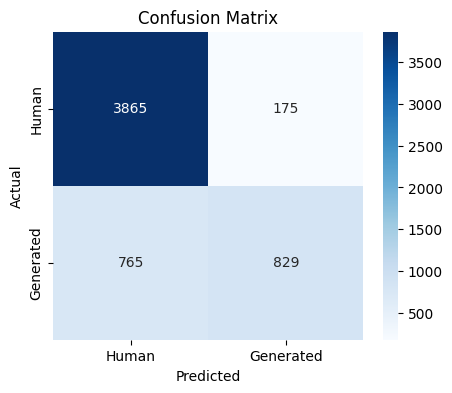

In [70]:
# Оценка модели
accuracy = accuracy_score(y_test, y_pred_adj)
print(f"Accuracy: {accuracy:.4f}")

print("Classification Report:")
print(classification_report(y_test, y_pred_adj))

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred_adj)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'Generated'], yticklabels=['Human', 'Generated'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### 5.3 SMOTE(sampling_strategy=0.6)

Этот параметр означает, что в класс 1 уйдет 60% от класса 0

In [71]:
# Настройка параметров SMOTE
smote = SMOTE(k_neighbors=5, sampling_strategy=0.6, random_state=42)

# Применение SMOTE
X_resampled, y_resampled = smote.fit_resample(X, y)

# Выводим баланс классов после SMOTE
print("Распределение классов после SMOTE:", Counter(y_resampled))

Распределение классов после SMOTE: Counter({0: 20121, 1: 12072})


In [72]:
# Теперь разделяем сбалансированные данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [73]:
# Преобразуем разреженную матрицу в плотную
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

In [74]:
# Обучение модели
rf = RandomForestClassifier(n_estimators=300, random_state=42, class_weight={0: 1, 1: 1}, 
                            max_depth=30, min_samples_leaf=2)

rf.fit(X_train_dense, y_train)

# Предсказание вероятностей
y_proba = rf.predict_proba(X_test_dense)[:, 1]  # Берем вероятности для класса "1"

# Предсказание с изменённым порогом
threshold = 0.42  # Можно попробовать 0.45-0.48
y_pred_adj = (y_proba > threshold).astype(int)

Accuracy: 0.8577
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.92      0.89      4050
           1       0.84      0.76      0.80      2389

    accuracy                           0.86      6439
   macro avg       0.85      0.84      0.84      6439
weighted avg       0.86      0.86      0.86      6439



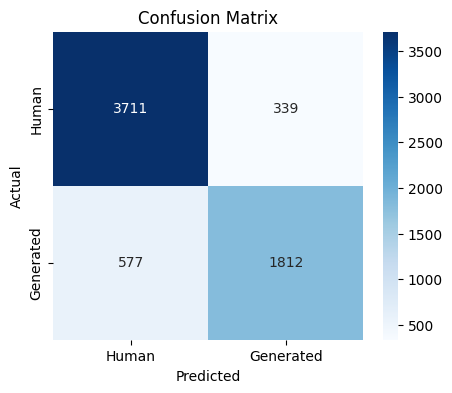

In [75]:
# Оценка модели
accuracy = accuracy_score(y_test, y_pred_adj)
print(f"Accuracy: {accuracy:.4f}")

print("Classification Report:")
print(classification_report(y_test, y_pred_adj))

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred_adj)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'Generated'], yticklabels=['Human', 'Generated'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### 5.4 SMOTE(sampling_strategy=0.8)

Этот параметр означает, что в класс 1 уйдет 80% от класса 0

In [76]:
# Настройка параметров SMOTE
smote = SMOTE(k_neighbors=5, sampling_strategy=0.8, random_state=42)

# Применение SMOTE
X_resampled, y_resampled = smote.fit_resample(X, y)

# Выводим баланс классов после SMOTE
print("Распределение классов после SMOTE:", Counter(y_resampled))

Распределение классов после SMOTE: Counter({0: 20121, 1: 16096})


In [77]:
# Теперь разделяем сбалансированные данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [78]:
# Преобразуем разреженную матрицу в плотную
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

In [79]:
# Обучение модели
rf = RandomForestClassifier(n_estimators=300, random_state=42, class_weight={0: 1, 1: 1}, 
                            max_depth=30, min_samples_leaf=2)

rf.fit(X_train_dense, y_train)

# Предсказание вероятностей
y_proba = rf.predict_proba(X_test_dense)[:, 1]  # Берем вероятности для класса "1"

# Предсказание с изменённым порогом
threshold = 0.42  # Можно попробовать 0.45-0.48
y_pred_adj = (y_proba > threshold).astype(int)

Accuracy: 0.8622
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      4057
           1       0.85      0.84      0.84      3187

    accuracy                           0.86      7244
   macro avg       0.86      0.86      0.86      7244
weighted avg       0.86      0.86      0.86      7244



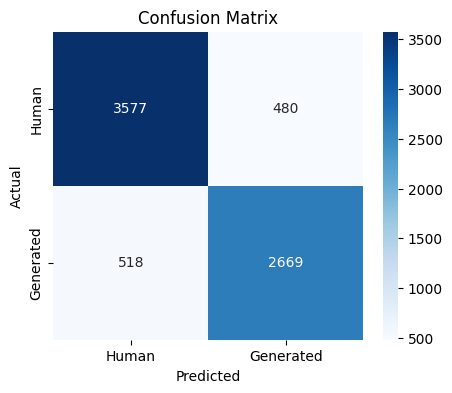

In [80]:
# Оценка модели
accuracy = accuracy_score(y_test, y_pred_adj)
print(f"Accuracy: {accuracy:.4f}")

print("Classification Report:")
print(classification_report(y_test, y_pred_adj))

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred_adj)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'Generated'], yticklabels=['Human', 'Generated'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()